# 3章 一般化線形モデル(GLM)

Rを使わないでPythonで処理の課程を再現する

## 3.3 統計モデリングの前にデータを図示する

In [5]:
df = pd.read_csv('./data3a.csv')

In [12]:
def draw_scatter(df):
    plt.scatter(df[df.f=='C'].x, df[df.f=='C'].y, color='r')
    plt.scatter(df[df.f=='T'].x, df[df.f=='T'].y, color='b')
    plt.legend([u'f == C', u'f == T(施肥)'], loc='upper left')

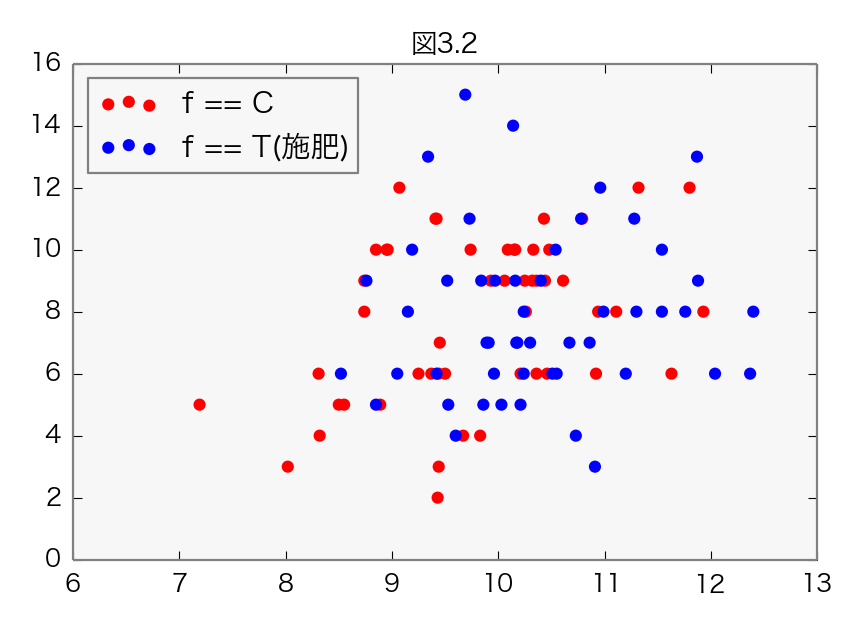

In [13]:
draw_scatter(df)
plt.title(u'図3.2')

(0, 15)

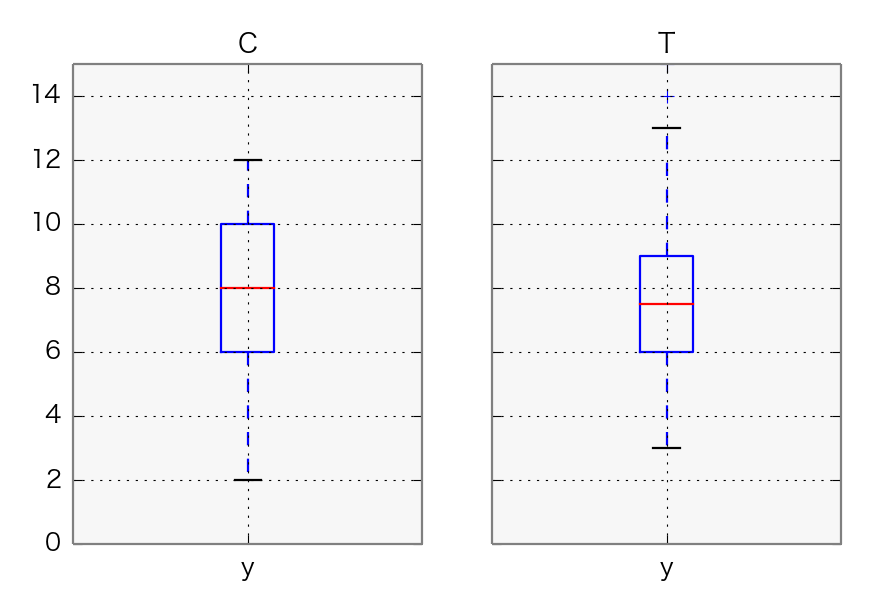

In [15]:
df.groupby(df.f).boxplot(column='y')
plt.ylim(0, 15)

## 3.4.1 線形予測と対数リンク関数

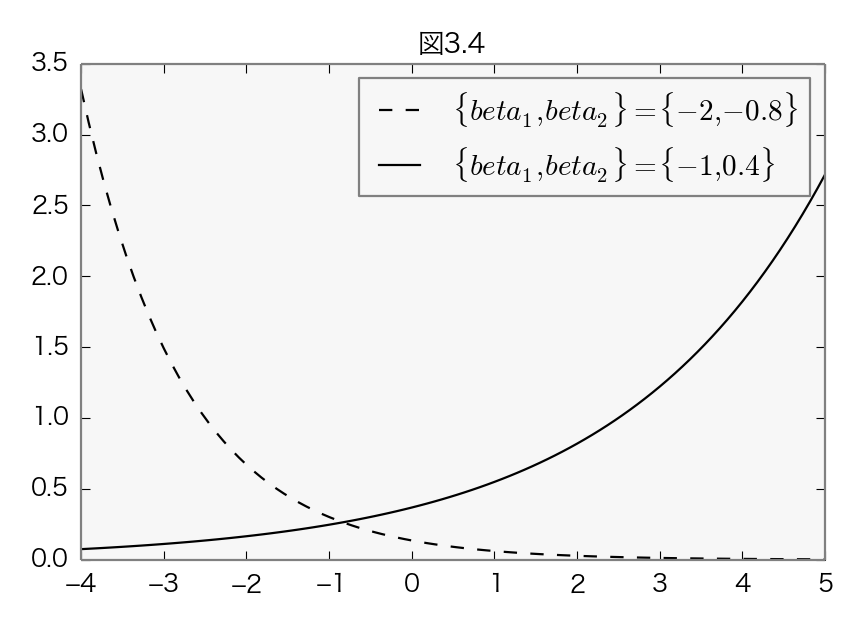

In [48]:
X = np.linspace(-4, 5, 100)
plt.plot(X, np.exp(-2 - 0.8*X), 'k--')
plt.plot(X, np.exp(-1 + 0.4*X), 'k-')
plt.legend(['$\{beta_1, beta_2\} = \{-2, -0.8\}$', '$\{beta_1, beta_2\} = \{-1, 0.4\}$'])
plt.title(u'図3.4')

## 3.4.2 あてはめと、あてはまりの良さ

In [49]:
def log_likelifood(b1, b2, x, y):
    # ポワソン回帰の対数尤度を返す
    ret = 0
    for i in range(x.size):
        ret += y[i] * (b1 + b2*x[i]) - np.exp(b1 + b2*x[i]) - sum(np.log(range(1, y[i])))
    return ret

独自で勾配降下を実装してみる

In [59]:
def climb_b1(b1, b2, x, y):
    # b2固定でb1を動かした時の最大の対数尤度を返す
    sign = +1
    alpha = 0.01

    logL = log_likelifood(b1, b2, x, y)
    
    while True:
        b1 += alpha * sign
        logL_n = log_likelifood(b1, b2, x, y)
        if np.abs(logL - logL_n) < 0.00001:
            break
        if logL_n < logL:
            sign = sign * -1
            alpha = alpha * 0.5
        else:
            alpha = alpha * 1.2
        logL = logL_n
    return logL, b1

def hill_climb(alpha, x, y):
    b1 = 1
    b2 = 0.1
    sign = +1
    
    max_logL, b1 = climb_b1(b1, b2, x, y)
    
    while True:
        b2 += alpha * sign
        # b2を動かした時の対数尤度を出す
        max_logL_n, b1 = climb_b1(b1, b2, x, y)
        # 変化しなくなったら終了
        if np.abs(max_logL_n - max_logL) < 0.00001:
            break
        if max_logL_n < max_logL:
            # 対数尤度が減ったら符号逆転
            sign = sign * -1
            alpha = alpha * 0.5
        else:
            alpha = alpha * 1.2            
        max_logL = max_logL_n
    print('Likelihood: %s, b1: %s, b2: %s' % (max_logL, b1, b2))
    return b1, b2

hill_climb(0.1, df.x.values, df.y.values)

Likelihood: -35.8338102468, b1: 1.29054140804, b2: 0.0757920975997


(1.2905414080350648, 0.07579209759971002)

statsmodelsを使うパターン

In [60]:
import statsmodels.api as sm
from statsmodels.formula.api import glm

def calc_x_related_model(df):
    return glm('y ~ x', data=df, family=sm.families.Poisson(sm.families.links.log)).fit()

In [61]:
x_related_model = calc_x_related_model(df)
x_related_model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                 Generalized Linear Model Regression Results                  
==============================================================================
Dep. Variable:                      y   No. Observations:                  100
Model:                            GLM   Df Residuals:                       98
Model Family:                 Poisson   Df Model:                            1
Link Function:                    log   Scale:                             1.0
Method:                          IRLS   Log-Likelihood:                -235.39
Date:                Wed, 04 Mar 2015   Deviance:                       84.993
Time:                        23:17:23   Pearson chi2:                     83.8
No. Iterations:                     7                                         
==============================================================================
                 coef    std err          z      P>|z|      [95.0% Conf. Int.]
------------------------------------------------------------------------------
Intercept      1.2917      0.364      3.552      0.000         0.579     2.005
x              0.0757      0.036      2.125      0.034         0.006     0.145
==============================================================================
"""

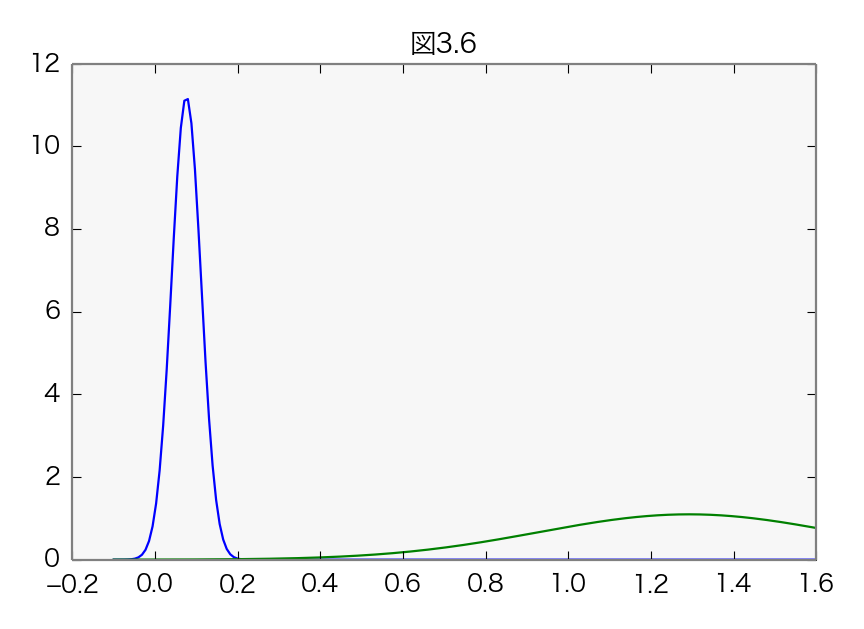

In [62]:
import scipy.stats
def plot_fig36(model):
    X = np.linspace(-0.1, 1.6, 200)
    plt.plot(X, scipy.stats.norm.pdf(X, loc=model.params[1], scale=model.bse[1]))
    plt.plot(X, scipy.stats.norm.pdf(X, loc=model.params.Intercept, scale=model.bse.Intercept))
    plt.title(u'図3.6')
    
plot_fig36(x_related_model)

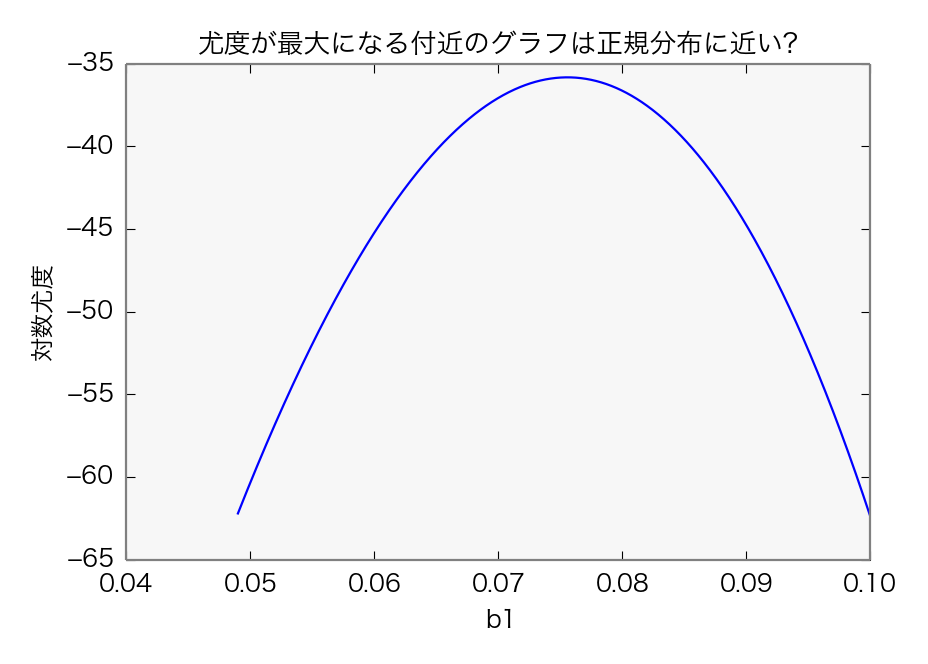

In [79]:
def plot_likelifood():
    X = np.linspace(0.049, 0.10, 1000)
    Y = []
    for x in X:
        Y.append(log_likelifood(1.2926, x, df.x.values, df.y.values))
    plt.plot(X, Y)
plot_likelifood()
plt.title(u'尤度が最大になる付近のグラフは正規分布に近い?')
plt.xlabel('b1')
plt.ylabel(u'対数尤度')

対数尤度の評価

In [64]:
x_related_model.llf

-235.38625076986077

AICで評価

In [65]:
x_related_model.aic

474.77250153972153

## 3.4.3 ポアソン回帰モデルによる予測

In [66]:
def draw_estimate_x(model):
    X = np.linspace(7, 13, 100)
    Y = model.predict({'x': X})
    plt.plot(X, Y, 'k-')

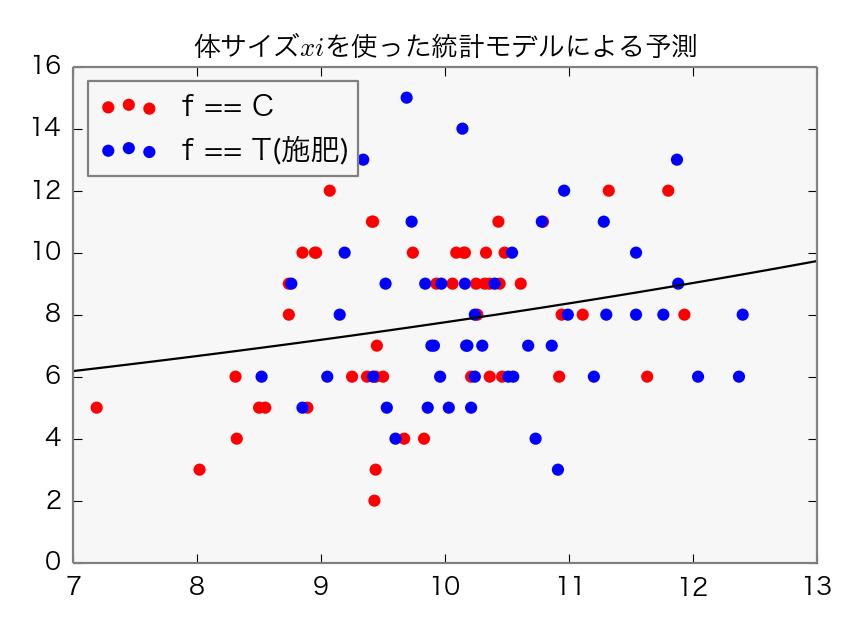

In [67]:
draw_scatter(df)
draw_estimate_x(x_related_model)
plt.xlim(7, 13)
plt.title(u'体サイズ$xi$を使った統計モデルによる予測')

## 3.5 説明変数が因子型の統計モデル

In [68]:
def calc_f_related_model(df):
    return glm('y ~ f', data=df, family=sm.families.Poisson(sm.families.links.log)).fit()

In [69]:
f_related_model = calc_f_related_model(df)
f_related_model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                 Generalized Linear Model Regression Results                  
==============================================================================
Dep. Variable:                      y   No. Observations:                  100
Model:                            GLM   Df Residuals:                       98
Model Family:                 Poisson   Df Model:                            1
Link Function:                    log   Scale:                             1.0
Method:                          IRLS   Log-Likelihood:                -237.63
Date:                Wed, 04 Mar 2015   Deviance:                       89.475
Time:                        23:17:31   Pearson chi2:                     87.1
No. Iterations:                     7                                         
==============================================================================
                 coef    std err          z      P>|z|      [95.0% Conf. Int.]
------------------------------------------------------------------------------
Intercept      2.0516      0.051     40.463      0.000         1.952     2.151
f[T.T]         0.0128      0.071      0.179      0.858        -0.127     0.153
==============================================================================
"""

In [70]:
def draw_estimate_f(model):
    X = np.linspace(7, 14, 1000)
    Y = model.predict({'x': X, 'f': ['C']*len(X)})
    plt.plot(X, Y, 'r-')
    Y = model.predict({'x': X, 'f': ['T']*len(X)})
    plt.plot(X, Y, 'b-')

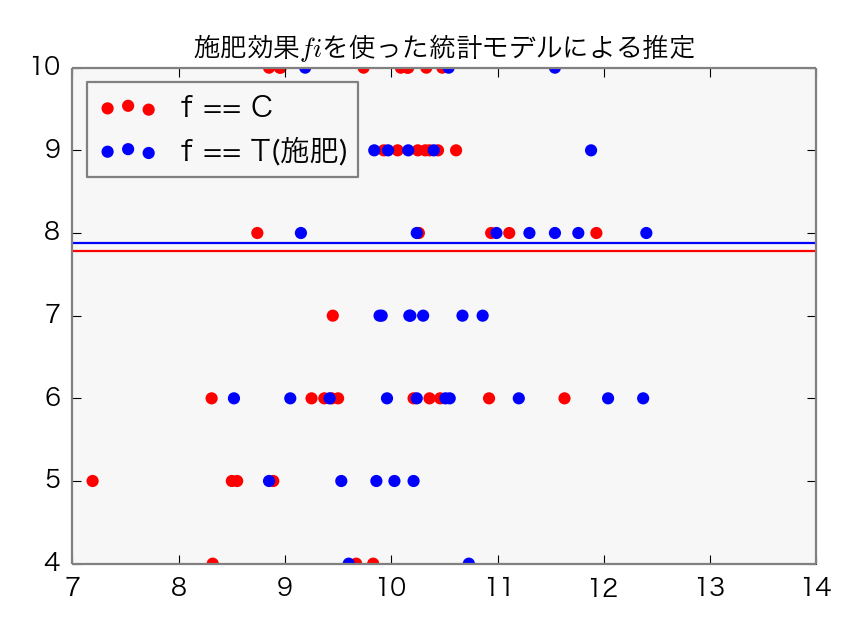

In [71]:
draw_scatter(df)
draw_estimate_f(f_related_model)
plt.xlim(7, 14)
plt.ylim(4, 10)
plt.title(u'施肥効果$fi$を使った統計モデルによる推定')

## 3.6 説明変数が数量型 + 因子型の統計モデル

In [72]:
def calc_x_f_related_model(df):
    return glm('y ~ x + f', data=df, family=sm.families.Poisson(sm.families.links.log)).fit()

In [73]:
x_f_related_model = calc_x_f_related_model(df)
x_f_related_model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                 Generalized Linear Model Regression Results                  
==============================================================================
Dep. Variable:                      y   No. Observations:                  100
Model:                            GLM   Df Residuals:                       97
Model Family:                 Poisson   Df Model:                            2
Link Function:                    log   Scale:                             1.0
Method:                          IRLS   Log-Likelihood:                -235.29
Date:                Wed, 04 Mar 2015   Deviance:                       84.808
Time:                        23:17:42   Pearson chi2:                     83.8
No. Iterations:                     7                                         
==============================================================================
                 coef    std err          z      P>|z|      [95.0% Conf. Int.]
------------------------------------------------------------------------------
Intercept      1.2631      0.370      3.417      0.001         0.539     1.988
f[T.T]        -0.0320      0.074     -0.430      0.667        -0.178     0.114
x              0.0801      0.037      2.162      0.031         0.007     0.153
==============================================================================
"""

In [74]:
def draw_estimate_x_f(model):
    X = np.linspace(7, 13, 100)
    Y = model.predict({'x': X, 'f': ['C']*len(X)})
    plt.plot(X, Y, 'r-')
    Y = model.predict({'x': X, 'f': ['T']*len(X)})
    plt.plot(X, Y, 'b-')

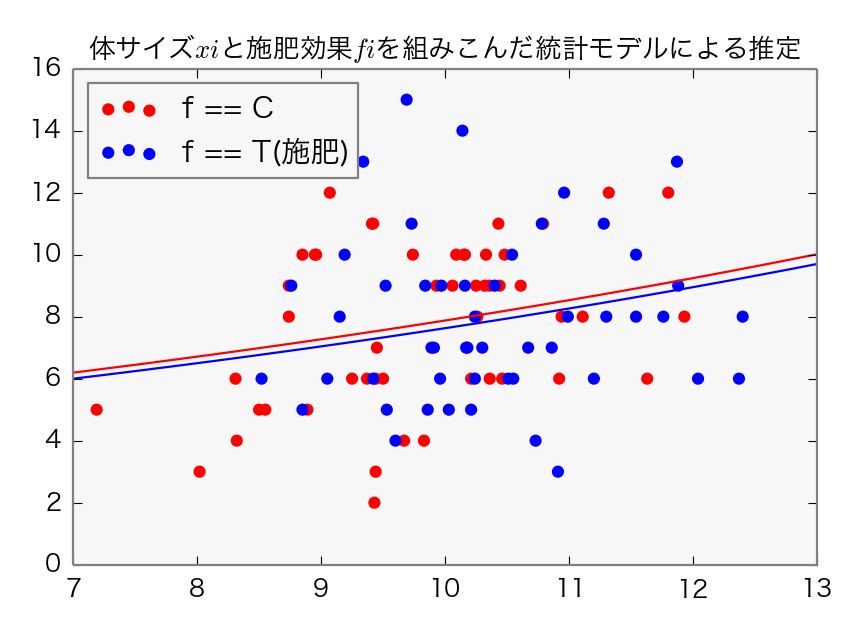

In [75]:
draw_scatter(df)
draw_estimate_x_f(x_f_related_model)
plt.xlim(7, 13)
plt.title(u'体サイズ$xi$と施肥効果$fi$を組みこんだ統計モデルによる推定')

In [44]:
glm('y ~ x + f', data=df, family=sm.families.Poisson(sm.families.links.identity)).fit().summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                 Generalized Linear Model Regression Results                  
==============================================================================
Dep. Variable:                      y   No. Observations:                  100
Model:                            GLM   Df Residuals:                       97
Model Family:                 Poisson   Df Model:                            2
Link Function:               identity   Scale:                             1.0
Method:                          IRLS   Log-Likelihood:                -235.16
Date:                Wed, 04 Mar 2015   Deviance:                       84.538
Time:                        20:13:50   Pearson chi2:                     83.6
No. Iterations:                     7                                         
==============================================================================
                 coef    std err          z      P>|z|      [95.0% Conf. Int.]
------------------------------------------------------------------------------
Intercept      1.2671      2.843      0.446      0.656        -4.306     6.840
f[T.T]        -0.2048      0.582     -0.352      0.725        -1.346     0.936
x              0.6606      0.290      2.281      0.023         0.093     1.228
==============================================================================
"""